# 2021-05-19 Adding delay penalty for waiting

Results below are for commit: https://github.com/gmarkkula/COMMOTIONSFramework/commit/53df88f8dcf6da15d3b5ca4008067b4234adc0e3 

(Rerunning the code below for other commits is not guaranteed to give the same results)

Extending the affordance-based value functions with also penalties for waiting and needing to regain free speed. Recapping what was already described in the diary entry from 2021-01-16: The value of a state $\mathbf{x}(t)$ assuming ego action $\mathbf{a}$ and a behaviour $\mathbf{b}$ from the other agent is:

$$
V[\mathbf{x}(t), \mathbf{a}, \mathbf{b}] = \max_{\Omega} V[\mathbf{x}(t), \mathbf{a}, \mathbf{b}, \Omega]
$$

where $\Omega \in \{ \Omega_{1st}, \Omega_{2nd} \}$ is the access order, and:

$$
V[\mathbf{x}(t), \mathbf{a}, \mathbf{b}, \Omega] = \int_t^{\infty} g[ v_{\mathbf{x}(t), \mathbf{a}, \mathbf{b}, \Omega}(t'), a_{\mathbf{x}(t), \mathbf{a}, \mathbf{b}, \Omega}(t') ] \delta(t' - t) \mathrm{d}t'
$$

where $v_{\mathbf{x}(t), \mathbf{a}, \mathbf{b}, \Omega}(t')$ and $a_{\mathbf{x}(t), \mathbf{a}, \mathbf{b}, \Omega}(t')$ are the future speeds and accelerations achieving $\Omega$ given  $\mathbf{x}(t)$, $\mathbf{a}$, and $\mathbf{b}$, $\delta(t)$ is a temporal discounting function:

$$
\delta(t) = 2^{-\frac{t}{T_{\delta}}} = e^{-\frac{\ln 2}{T_{\delta}}t}
$$

and $g[v, a]$ is a value rate (or reward/punishment rate) function:

$$
g[v, a] = k_g v - k_{dv} v^2 - k_{da} a^2.
$$

The value integral is estimated as follows:

$$
\begin{align}
V[\mathbf{x}(t), \mathbf{a}, \mathbf{b}, \Omega] \approx & \int_t^{T_\mathrm{p}} g_1(t') \mathrm{d}t' \\
                                                         & + \delta(T_\mathrm{p}) \int_{t+T_\mathrm{p}}^{T_\mathrm{p}+T_{\Omega}} g_2(t') \mathrm{d}t' \\
                                                         & + \delta(T_\mathrm{p}+T_{\Omega}+T_\mathrm{dw}) \int_{t+T_\mathrm{p}+T_{\Omega}+T_\mathrm{dw}}^{T_\mathrm{p}+T_{\Omega}+T_\mathrm{dw}+T_\mathrm{dr}} g_3(t') \mathrm{d}t' \\
                                                         & + \int_{t+T_\mathrm{p}+T_{\Omega}+T_\mathrm{dw}+T_\mathrm{dr}}^{\infty} g[v^*,0] \delta(t'-t) \mathrm{d}t'
\end{align}
$$

where each integral corresponds to a period with constant jerk: (i) The prediction interval $T_\mathrm{p}$ described by $g_1$, (ii) the subsequent interval of duration $T_{\Omega}$ during which the access order in question is achieved, described by $g_2$, (iii) a possible waiting time interval of duration $T_\mathrm{dw}$, with zero value, (iv) an interval of duration $T_\mathrm{dr}$ during which the free speed is regained, described by $g_3$, and (v) the rest of the trip, carried out at the free speed. 

The moving of the delay discounting function $\delta$ to outside of the integral is a decent approximation as long as the integration time intervals are much shorter than $T_\delta$, such that $\delta$ is close to constant within the integral. As shown in my physical notebook notes dated 2020-12-22, as long as the time left until the end of the trip after the interaction is substantially greater than $T_\delta$, the final integral can be approximated as:

$$
\int_{t+T_\mathrm{p}+T_{\Omega}+T_\mathrm{dw}+T_\mathrm{dr}}^{\infty} g[v^*,0] \delta(t'-t) \mathrm{d}t' \approx \delta(T_\mathrm{p}+T_{\Omega}+T_\mathrm{dw}+T_\mathrm{dr}) g[v^*,0] \frac{T_\delta}{\ln 2}
$$




## Init

In [1]:
# put root folder of repo PYTHONPATH (https://stackoverflow.com/questions/714063/importing-modules-from-parent-folder)
import sys
from pathlib import Path
sys.path.append(str(Path('.').absolute().parent))
print(sys.path[-1])

# imports needed to run the simulations
import numpy as np
import commotions
import sc_scenario
from sc_scenario import get_assumptions_dict, SCSimulation
from sc_scenario_helper import CtrlType

C:\GITHUB\COMMOTIONSFramework


C:\GITHUB\COMMOTIONSFramework\sc_scenario.py:89: UserWarning: N_ACTIONS set to no of actions in default params, so will not work if non-default params are set.
  warnings.warn('N_ACTIONS set to no of actions in default params, so will not work if non-default params are set.')


## Just the base model - no interaction

Just verifying that the base model without interaction still works (a good thing I did this - because it actually did break briefly when I introduced the delay penalty for waiting...).

C:\GITHUB\COMMOTIONSFramework\sc_scenario.py:190: UserWarning: ****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.
  warnings.warn('****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.')
C:\GITHUB\COMMOTIONSFramework\sc_scenario.py:1044: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(N_PLOTROWS, 1, 1)
C:\GITHUB\COMMOTIONSFramework\sc_scenario.py:1050: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured,

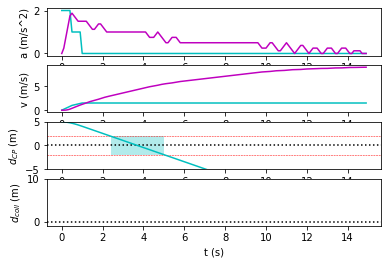

In [3]:
CTRL_TYPES = (CtrlType.SPEED, CtrlType.ACCELERATION) 
INITIAL_POSITIONS = np.array([[0,-5], [400, 0]])
GOALS = np.array([[0, 5], [-50, 0]])
SPEEDS = np.array((0, 0))

optional_assumptions = get_assumptions_dict(
        default_value = False, oBEao = False, oBEvs = False, oEA = False)  
sc_simulation = SCSimulation(
        CTRL_TYPES, GOALS, INITIAL_POSITIONS, initial_speeds = SPEEDS, 
        end_time = 15, optional_assumptions = optional_assumptions,
        agent_names = ('P', 'V'))
sc_simulation.run()
sc_simulation.do_plots(kinem_states = True, surplus_action_vals = False)

## `oBEvs` with the added delay penalty

And testing the good old baseline kinematical scenario with `oBEvs`. Getting quite similar behaviour to previously, but possibly looks slightly nicer. 

And we do get the kind of separation I expected based on the argument in the previous entry: At for example 2.5 s, the pedestrian believes that keeping its current speed will mean that the car will want to pass first, whereas increasing speed will mean that the car will want to pass second, and in both cases the pedestrian then still prefers the access order ego second, but now there is a difference between the two car behaviours, because if the car tries to pass second, then the pedestrian will need to wait longer. Therefore there is a (small) deviation between the two $V(0.5|b)$ at 2.5, with a slightly higher value for $b$ = Pass1st.

Seemingly as a result, the pedestrian decelerates a bit at 0.5-1 s, which means that the car doesn't need to accelerate as much to assert itself. (And there is also no slight collision here - but I think that's just luck - if I was right in my previous diary entry about what causes it then it should still be there, just didn't happen in these specific circumstances - as can be seen in some simulations further below in this notebook.)

C:\GITHUB\COMMOTIONSFramework\sc_scenario.py:190: UserWarning: ****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.
  warnings.warn('****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.')
C:\GITHUB\COMMOTIONSFramework\sc_scenario.py:1034: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(N_PLOTROWS, 1, 1)
C:\GITHUB\COMMOTIONSFramework\sc_scenario.py:1040: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured,

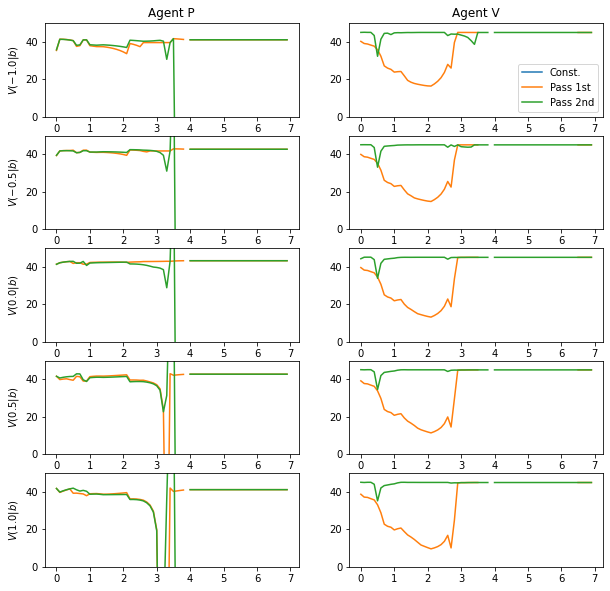

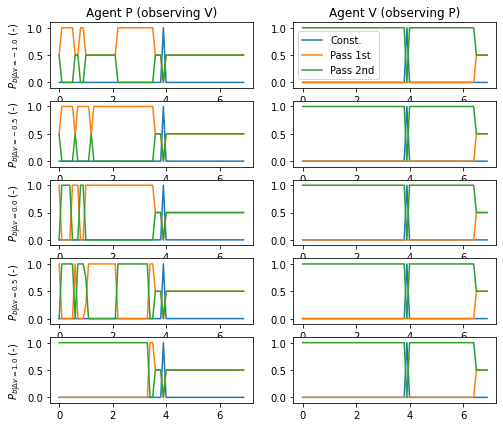

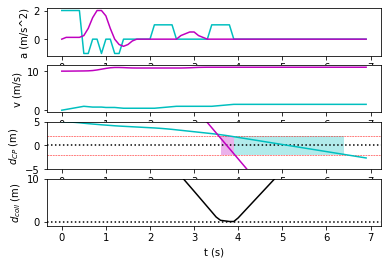

In [4]:
INITIAL_POSITIONS = np.array([[0,-5], [40, 0]])
SPEEDS = np.array((0, 10))

(params, params_k) = sc_scenario.get_default_params()
optional_assumptions = get_assumptions_dict(
        default_value = False, oBEao = False, oBEvs = True, oEA = False)  
sc_simulation = SCSimulation(
        CTRL_TYPES, GOALS, INITIAL_POSITIONS, initial_speeds = SPEEDS, 
        end_time = 7, optional_assumptions = optional_assumptions,
        params = params, agent_names = ('P', 'V'))
sc_simulation.run()
sc_simulation.do_plots(
        kinem_states = True, beh_probs = True, beh_accs = False, surplus_action_vals = False, action_vals = True)

Adding support for constant-speed agents, first just rerunning the same scenario again, but with the car agent fixed at its initial speed, causing the pedestrian agent some concern, but ultimately it decides to let the car agent pass first:

C:\GITHUB\COMMOTIONSFramework\sc_scenario.py:190: UserWarning: ****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.
  warnings.warn('****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.')
C:\GITHUB\COMMOTIONSFramework\sc_scenario.py:1044: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(N_PLOTROWS, 1, 1)
C:\GITHUB\COMMOTIONSFramework\sc_scenario.py:1050: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured,

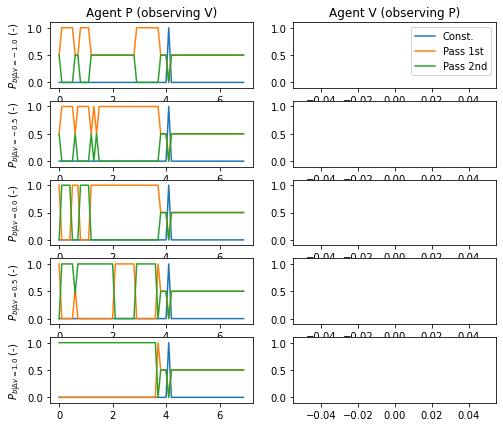

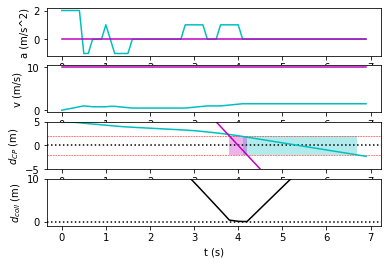

In [5]:
INITIAL_POSITIONS = np.array([[0,-5], [40, 0]])
SPEEDS = np.array((0, 10))
CONST_SPEEDS = (False, True)

(params, params_k) = sc_scenario.get_default_params()
optional_assumptions = get_assumptions_dict(
        default_value = False, oBEao = False, oBEvs = True, oEA = False)  
sc_simulation = SCSimulation(
        CTRL_TYPES, GOALS, INITIAL_POSITIONS, initial_speeds = SPEEDS, 
        end_time = 7, optional_assumptions = optional_assumptions,
        params = params, agent_names = ('P', 'V'), const_speeds = CONST_SPEEDS)
sc_simulation.run()
sc_simulation.do_plots(
        kinem_states = True, beh_probs = True, beh_accs = False, surplus_action_vals = False, action_vals = False)

Now increasing the initial distance of the car to a point where the pedestrian just barely lets the car pass first:

C:\GITHUB\COMMOTIONSFramework\sc_scenario.py:190: UserWarning: ****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.
  warnings.warn('****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.')
C:\GITHUB\COMMOTIONSFramework\sc_scenario.py:1044: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(N_PLOTROWS, 1, 1)
C:\GITHUB\COMMOTIONSFramework\sc_scenario.py:1050: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured,

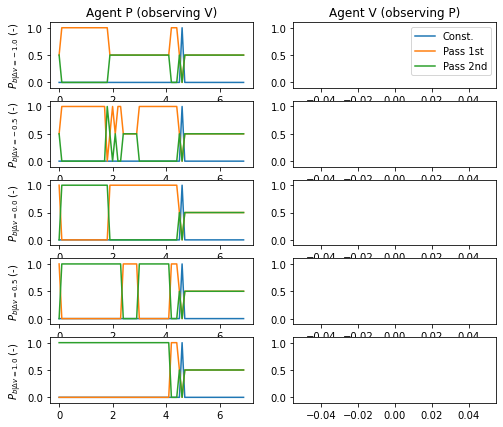

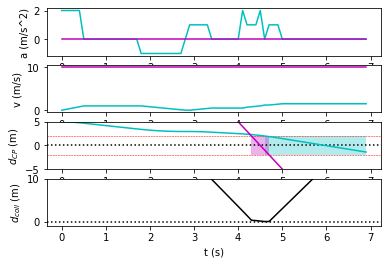

In [7]:
INITIAL_POSITIONS = np.array([[0,-5], [45, 0]])

params.T_delta = 30 # s; the default value

sc_simulation = SCSimulation(
        CTRL_TYPES, GOALS, INITIAL_POSITIONS, initial_speeds = SPEEDS, 
        end_time = 7, optional_assumptions = optional_assumptions,
        params = params, agent_names = ('P', 'V'), const_speeds = CONST_SPEEDS)
sc_simulation.run()
sc_simulation.do_plots(
        kinem_states = True, beh_probs = True, beh_accs = False, surplus_action_vals = False, action_vals = False)

If we now reduce $T_\delta$, we get a pedestrian that is more averse to delaying rewards into the future, and who therefore responds to the same kinematical situation by instead speeding up to pass in front of the vehicle:

C:\GITHUB\COMMOTIONSFramework\sc_scenario.py:190: UserWarning: ****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.
  warnings.warn('****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.')
C:\GITHUB\COMMOTIONSFramework\sc_scenario.py:1044: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(N_PLOTROWS, 1, 1)
C:\GITHUB\COMMOTIONSFramework\sc_scenario.py:1050: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured,

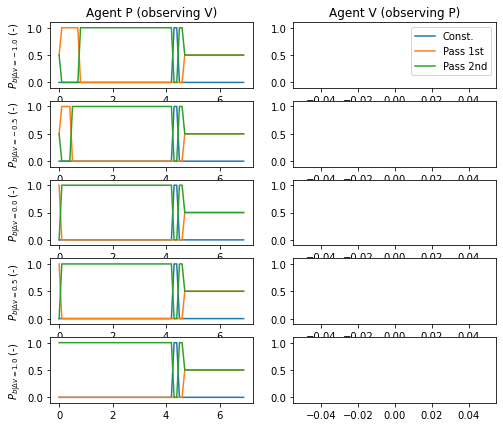

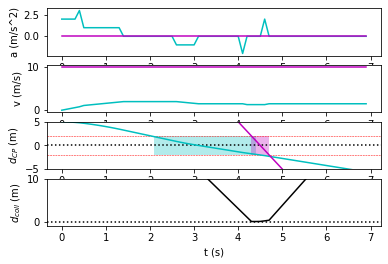

In [8]:
params.T_delta = 10 # s; a lower value

sc_simulation = SCSimulation(
        CTRL_TYPES, GOALS, INITIAL_POSITIONS, initial_speeds = SPEEDS, 
        end_time = 7, optional_assumptions = optional_assumptions,
        params = params, agent_names = ('P', 'V'), const_speeds = CONST_SPEEDS)
sc_simulation.run()
sc_simulation.do_plots(
        kinem_states = True, beh_probs = True, beh_accs = False, surplus_action_vals = False, action_vals = False)

Note that the behaviour estimation assumption (`oBEvs`) actually affects the outcome above, even though the car is in fact not at all responding to the pedestrian's behaviour. This can be seen below, where the $T_\delta$ change has a smaller effect when `oBEvs` is removed. The main difference is that without `oBEvs`, the pedestrian assumes the car will always keep constant speed (which in this case is actually true), whereas with `oBEvs`, the pedestrian assumes that the car will always behave so as to pass either in front or behind of themselves.

C:\GITHUB\COMMOTIONSFramework\sc_scenario.py:190: UserWarning: ****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.
  warnings.warn('****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.')


T_delta = 30 s


C:\GITHUB\COMMOTIONSFramework\sc_scenario.py:1044: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(N_PLOTROWS, 1, 1)
C:\GITHUB\COMMOTIONSFramework\sc_scenario.py:1050: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(N_PLOTROWS, 1, 2)
C:\GITHUB\COMMOTIONSFramework\sc_scenario.py:1056: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.

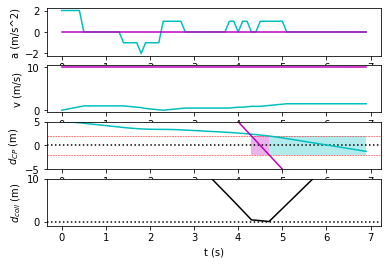

C:\GITHUB\COMMOTIONSFramework\sc_scenario.py:190: UserWarning: ****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.
  warnings.warn('****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.')
C:\GITHUB\COMMOTIONSFramework\sc_scenario.py:1044: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(N_PLOTROWS, 1, 1)
C:\GITHUB\COMMOTIONSFramework\sc_scenario.py:1050: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured,

T_delta = 10 s


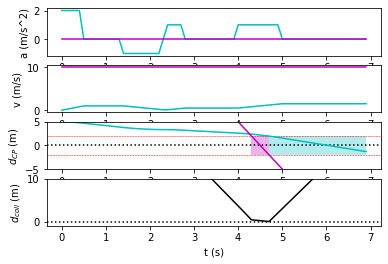

In [16]:
optional_assumptions = get_assumptions_dict(
        default_value = False, oBEao = False, oBEvs = False, oEA = False)  

for T_delta in (30, 10):
    params.T_delta = T_delta # s; the default value
    sc_simulation = SCSimulation(
            CTRL_TYPES, GOALS, INITIAL_POSITIONS, initial_speeds = SPEEDS, 
            end_time = 7, optional_assumptions = optional_assumptions,
            params = params, agent_names = ('P', 'V'), const_speeds = CONST_SPEEDS)
    sc_simulation.run()
    print('T_delta = %i s' % T_delta)
    sc_simulation.do_plots(
            kinem_states = True, beh_probs = False, beh_accs = False, surplus_action_vals = False, action_vals = False)

At this point I have ticked off all the major things that were left open since the 2021-01-16 diary entry. **A nice next step might be to start looking at the `oBEao` assumption, alone and together with `oBEvs`.**